In [1]:
import warnings
import sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import config
import SLM_utils as slm
plt.style.use("bmh")
import figure_utils
from scipy import stats 
from scipy import special
from numba import jit
from matplotlib.gridspec import GridSpec
from matplotlib import rc
rc('text', usetex=True)
import plot_cluster_utils as pcu
from matplotlib.lines import Line2D
from scipy.stats import gamma
from scipy.stats import chisquare
from scipy.special import erfinv
from scipy.stats import shapiro

SMALL_SIZE=15
MEDIUM_SIZE=20

rc('legend', fontsize=MEDIUM_SIZE)
rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=SMALL_SIZE)  
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821']

In [ ]:
def afd_gamma(X_bar,beta):

    return gamma(beta,scale=X_bar/beta)

In [ ]:
def sigma_2_xi(Ns,ns_i):
   # Ns = count_reads.sum()
   # ns_i = count_reads.loc[species]
    return(np.mean((ns_i*(ns_i - 1)/(Ns*(Ns-1)))) - np.mean(ns_i/Ns)**2)

In [ ]:
@jit
def SLM(x_0,tau,sgm,K,T,nse,delta_t):
     
    X = [x_0]
    sqrt_delta_t = np.sqrt(delta_t)
    sqrt_sig_tau = np.sqrt(sgm/tau)
    
    for i in range(T):
        
        X_t = X[-1]
        
        X_t += (X_t/tau)*(1 - X_t/K)*delta_t + sqrt_sig_tau*X_t*nse[i]*sqrt_delta_t        
        
        X.append(X_t)    
    
    return(X)

In [264]:
species = "Bacteroides_uniformis_57318"
host = "an"
#strain_total_freqs = pcu.get_strain_total_freqs(species,host)
strain_total_freqs = pd.read_csv(f"{config.analysis_directory}final_paper_clusters/{host}/{species}_clusters",index_col=0).T
samples = strain_total_freqs.index

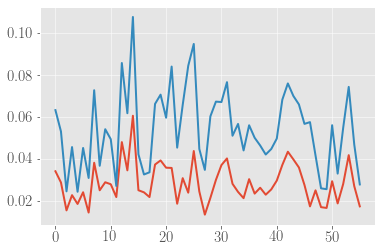

In [265]:
plt.plot(strain_total_freqs.values);

In [263]:
dates = pd.read_pickle("metadata/Poyet_collection_dates.pkl")
species_dates = pd.to_datetime(dates[strain_total_freqs.index].sort_values())
basedate = species_dates.iloc[0]

species_dates = ((species_dates - basedate).dt.days).values
intervals = np.diff(species_dates)
intervals[intervals == 0] = 1
species_dates = np.insert(intervals,0,0)
strain_total_freqs["Date_Diffs"] = species_dates
strain_total_freqs["Order"] = np.arange(strain_total_freqs.shape[0])

KeyError: "None of [Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',\n       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',\n       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',\n       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',\n       '49', '50', '51', '52', '53', '54', '55'],\n      dtype='object')] are in the [index]"

In [252]:
strain = 1
count_reads = pd.read_csv(f"{config.data_directory}species/count_reads.txt.bz2",sep="\t",index_col=0)
Ns = count_reads.sum()
ns_i = strain_total_freqs[strain]*Ns
times = np.cumsum(strain_total_freqs["Date_Diffs"])
times = list(times)

if 0 in strain_total_freqs[strain].values:
    dropind = np.argwhere((strain_total_freqs[strain] == 0).values)[0][0]
    del times[dropind]
    strain_total_freqs = strain_total_freqs.loc[strain_total_freqs[strain] != 0]
    
times = np.array(times)
N = len(times)
T = times[-1]
count_reads = pd.read_csv(f"{config.data_directory}species/count_reads.txt.bz2",sep="\t",index_col=0)
Ns = count_reads.sum()
ns_i = strain_total_freqs[strain]*Ns

strain_freq = strain_total_freqs[strain]

beta = (strain_freq.mean()**2/sigma_2_xi(Ns,ns_i))
#beta = (strain_freq.mean()**2/strain_freq.var())
sigma = 2/(beta+1)
xbar = np.mean(strain_freq)
K = xbar/(1-sigma/2)
afd = afd_gamma(xbar,beta)
x0 = afd.rvs(int(1e4))
ci = [afd.ppf(.05),afd.ppf(.95)]
xrange = np.logspace(-10,0,int(1e4))
xrange[0] = 0
stationary = afd.pdf(xrange)

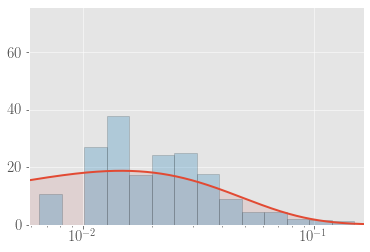

In [253]:
fig, ax = plt.subplots(figsize=(6,4))
        
ax.plot(xrange,stationary)
ax.fill_between(xrange,stationary,alpha=.1,color="firebrick",zorder=0)
n=ax.hist(strain_freq,bins=np.logspace(np.log10(min(strain_freq)),np.log10(max(strain_freq)),15),density=True,alpha=.3,ec="k")
ax.semilogx()
ax.set_xlim([.9*min(n[1]),1.1*max(n[1])])
ax.set_ylim([0,2*max(n[0])]);

In [254]:
sigma

0.7653408244825229

In [255]:
K

0.06255772808973348

In [256]:
intervals = np.diff(times)
delta_t = 1/1000
X_list = []
tau = 1

M = 10
all_next = []

p = []
Qt = 0
Qt_l = []
A = []
nt = 50
for _ in range(nt):
    
    all_next = []

    for j in range(len(intervals)):
        
        X_list = []
        for i in range(M):
            
            T = intervals[j]
            ns = np.random.normal(0, 1, int(T/delta_t))
            simvals = SLM(strain_freq[j],tau,sigma,K,int(T/delta_t),ns,delta_t)
            
            next_val = simvals[-1]
            
            X_list.append(next_val)
                
        all_next.append(X_list)
        
    all_next = np.array(all_next)
    A.append(all_next)

    if _ % 100 == 0:
        print(_)
    


0


In [257]:
mm = []
for j in range(len(A)):
    m = []

    for i in range(len(strain_freq.values) - 1):
        m.append(1+np.sum(A[j][i] > strain_freq.values[i+1]))
    mm.append(m)

In [258]:
mm = np.array(mm)

In [259]:
b = M+1
Qt = []
for i in range(len(mm)):
    n = plt.hist(mm[i],bins=np.arange(1,b+2))
    plt.close()
    q=sum(((N-1)/(M+1) - n[0])**2)/((N-1)/(M+1))
    Qt.append(q)

In [260]:
1 - stats.chi2.cdf(np.mean(Qt),df = M-2)

0.08582192410186229